In [2]:
#Relative Strength Index

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


Price,Adj Close,Close,High,Low,Open,Volume,RSI,Strategy,Asset_Returns,Strategy_Returns
Date,,,,,,,,,,
2021-07-27,414.858643,439.010010,439.940002,435.989990,439.910004,67397100,55.525905,0.0,NaN,NaN
2021-07-28,414.688568,438.829987,440.299988,437.309998,439.679993,52472400,60.460178,0.0,-0.000410,0.00000
2021-07-29,416.408356,440.649994,441.799988,439.809998,439.820007,47435300,57.322309,0.0,0.003736,0.00000
2021-07-30,414.386139,438.510010,440.059998,437.769989,437.910004,68951200,52.007898,0.0,-0.001139,0.00000
2021-08-02,413.516693,437.589996,440.929993,437.209991,440.339996,58783300,52.853883,0.0,-0.003235,0.00000
...,...,...,...,...,...,...,...,...,...,...
2025-06-24,606.780029,606.780029,607.849976,603.409973,604.330017,67735300,60.582051,0.0,0.382155,0.20577
2025-06-25,607.119995,607.119995,608.609985,605.539978,607.909973,62114800,61.037682,0.0,0.382930,0.20577
2025-06-26,611.869995,611.869995,612.309998,608.369995,608.989990,78548400,67.903356,0.0,0.393750,0.20577


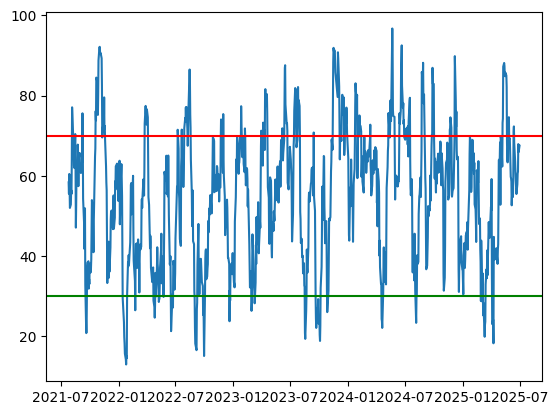

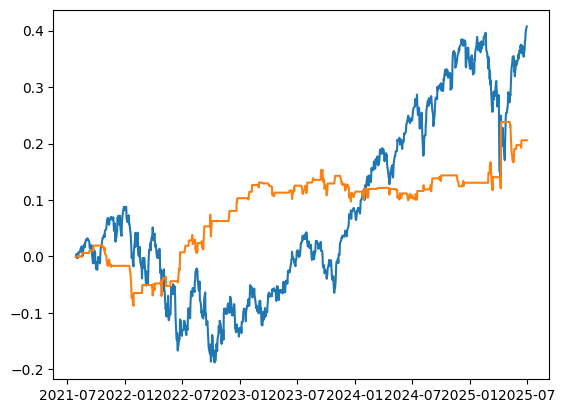

In [3]:
#momentum shift indicator, 30 and 70 are ranges, when below 30 should come up soon(oversold) and 
# when above 70 (overbought) should come down soon

TICKER = 'SPY'
RSI_LENGTH = 14
OVERBOUGHT = 70
OVERSOLD = 30
LOOKBACK = 1000

def get_data(ticker=TICKER, lookback=LOOKBACK):
    df = yf.download(
        ticker,
        start='1993-01-29',
        end='2025-07-01',
        interval='1d',
        auto_adjust=False,
        progress=False,
        threads=False
    )
    df.columns = df.columns.get_level_values(0)
    return df.dropna().iloc[-lookback:, :]


def add_RSI(df, length = RSI_LENGTH):
    
    #delta is change in price, diff shows diff between given row

    price_change = df['Close'].diff()

    #seperate gains and losses
    gain = price_change.where(price_change>0,0)
    loss = -price_change.where(price_change<0,0)

    #average gain vs loss
    avg_gain = gain.rolling(window=length).mean()
    avg_loss = loss.rolling(window=length).mean()

    #what % of each have the gains and losses been (RSI)
    rs = avg_gain/avg_loss
    rsi = 100 - (100/(1+rs))

    df['RSI'] = rsi

    plt.plot(df['RSI'])
    plt.axhline(OVERBOUGHT, color = 'red') # # above red: overbought, potential short
    plt.axhline(OVERSOLD, color = 'green') # # below green: oversold, potential long

    return df.dropna()
    

def add_strategy(df, overbought = OVERBOUGHT, oversold = OVERSOLD):

    df.columns = df.columns.get_level_values(0)

    df['Strategy'] = 0
    df['Strategy'] = np.where(df['RSI']>overbought,-1,
                              np.where(df['RSI']<oversold,1,0))
    df['Strategy'] = df['Strategy'].shift(1)

    return df.dropna()


def test_strategy(df):

    df['Asset_Returns'] = (1 + df['Close'].pct_change()).cumprod() - 1
    df['Strategy_Returns'] = (1 + df['Close'].pct_change()*df['Strategy']).cumprod() - 1
    

    plt.figure()
    plt.plot(df['Asset_Returns'])
    plt.plot(df['Strategy_Returns'])

    return df



def main():
    df = get_data()
    df = add_RSI(df)
    df = add_strategy(df)
    df = test_strategy(df)

    return df

main()




In [25]:
df['Strategy'].value_counts()

Strategy
 0.0    732
-1.0    182
 1.0     72
Name: count, dtype: int64